In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

from zipfile import ZipFile
file_name = "/content/gdrive/MyDrive/fer2013.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Mounted at /content/gdrive
Done


In [ ]:
import torch
import torchvision
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import tqdm
from collections import Counter
import torch.utils.data as data
import cv2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

Initializing Required Functions

In [ ]:
from collections import defaultdict
def CalcDescriptor(img, step_size=30, patch_size=16):
    # Convert the image to grayscale if necessary
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()
    
    # Create a Dense SIFT object
    sift = cv2.xfeatures2d.SIFT_create()

    # Create a grid of keypoints at regularly spaced intervals
    keypoints = [cv2.KeyPoint(x, y, patch_size) for y in range(0, gray.shape[0], step_size)
                                                 for x in range(0, gray.shape[1], step_size)]

    # Compute the descriptors at the keypoints
    _, descriptors = sift.compute(gray, keypoints)
    
    return keypoints, descriptors

def ProcessDataset(loader):

    descriptors = []
    labels = []
    key_points =[]
    images =[]
    descriptor_list = []
    for i, l in loader:
      key=int(l)
  
      x = i.squeeze()
  
      # convert the tensor to a numpy array
      x_np = x.numpy()

      #scaling values and converting data type to uint8 which is needed by the feature extractor
      img_scaled = np.uint8(x_np * 255)
      img_uint8 = cv2.convertScaleAbs(img_scaled)
       
     
      #calling feature extractor
      kp,features = CalcDescriptor(img_uint8)
      #print(len(features))
      # Append the features and label to the dataset
      if features is not None:
        descriptors.append(features)
        
        labels.append(key)
        key_points.append(kp)
        images.append(img_uint8)
    print('Before')
    print(len(descriptors))
    descriptors_list = descriptors
    descriptors = np.vstack(descriptors)
    print('After')
    print(len(descriptors))

    return images,key_points,descriptors,descriptors_list,labels

In [ ]:
def ComputeClusters(desc,k):
  # Create a KMeans model with k clusters
  kmeans = KMeans(n_clusters = k, n_init=10)
  kmeans.fit(desc)
  objects_visual_words = kmeans.cluster_centers_

  return objects_visual_words

In [ ]:
import numpy as np

# Function to find the index of the closest visual word to a given feature
def find_index(feature, visual_words):
    distances = []
    for word in visual_words:
        distance = np.linalg.norm(feature - word)  # Calculate the Euclidean distance between feature and word
        distances.append(distance)  # Append the distance to the distances list
      
    return np.argmin(distances, axis=0)  # Return the index of the minimum distance


# Function to compute the histogram of visual words for each image
def image_class(bovw, labels, centers):
    dict_feature = {}
    vec = []  # List to store the histograms of visual words for each image
    lab = []  # List to store the corresponding labels

    for i in range(len(bovw)):
        img = bovw[i]
        histogram = np.zeros(len(centers))  # Initialize the histogram with zeros for each image
        for each_feature in img:
            ind = find_index(each_feature, centers)  # Find the index of the closest visual word to the feature
            histogram[ind] += 1  # Increment the count at the corresponding index in the histogram
        vec.append(histogram)  # Append the histogram to the vec list
        lab.append(labels[i])  # Append the corresponding label to the lab list

    return vec, lab  # Return the lists of histograms and labels


In [ ]:
def VisualizeResults(y_true,y_pred):
  #confusion Matrix
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, fmt='.0f', cmap="Blues")
  plt.title("Confusion Matrix")
  plt.ylabel("True Label")
  plt.xlabel("Predicted Label")
  plt.show(block=False)

  # Classification Report Visualization
  cr_dict = classification_report(y_true, y_pred, output_dict=True)
  cr_df = pd.DataFrame(cr_dict).transpose()

  sns.heatmap(cr_df.iloc[:-1, :].T, annot=True, fmt='.2f', cmap="Blues")
  plt.title("Classification Report")
  plt.show(block=False)

Objects Dataset

In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize((256,256)),torchvision.transforms.Grayscale(num_output_channels=1)])

train_data_path = '/content/fer2013/train/'
test_data_path = '/content/fer2013/test/'

train_dataset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root=test_data_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1)
test_loader = DataLoader(test_dataset, batch_size=1)

In [ ]:
images,key_points,descriptors,descriptors_list,lables = ProcessDataset(train_loader)
images_test,key_points_test,descriptors_test,descriptors_list_test,lables_test = ProcessDataset(test_loader)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Before
28709
After
2325429
Before
7178
After
581418


In [ ]:
visual_words = ComputeClusters(descriptors,100)

In [ ]:
# Creates histograms for train data    
x_train, y_train = image_class(descriptors_list,lables, visual_words) 
x_test, y_test = image_class(descriptors_list_test,lables_test, visual_words) 

In [ ]:
print(len(x_train),len(y_train))
print(len(x_test),len(y_test))

28709 28709
7178 7178


In [ ]:
from sklearn.svm import SVC

clf = SVC(kernel='rbf',gamma=0.01,C=2.2)
clf.fit(x_train, y_train)
preds = clf.predict(x_test)

In [ ]:
accuracy = accuracy_score(y_test, preds)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 43.24%


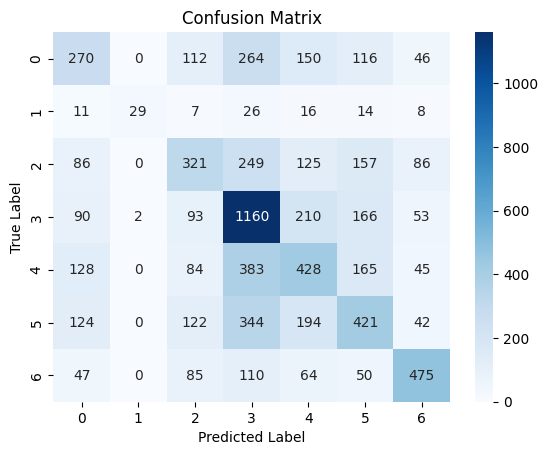

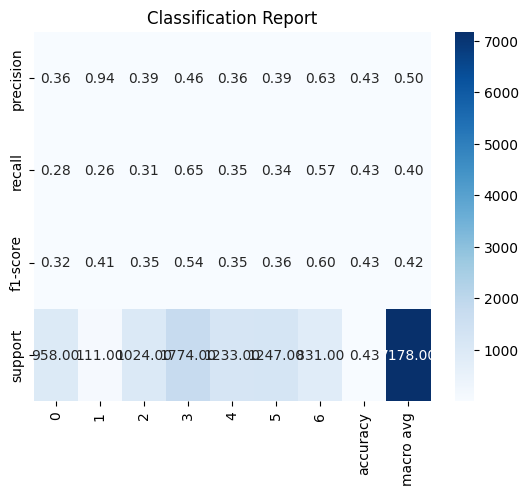

In [ ]:
VisualizeResults(y_test,preds)

Wrong Classification
True Lable :  0
Predicted Lable :  5


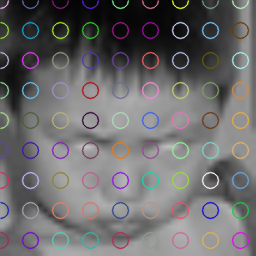

In [ ]:
# Draw the keypoints on the image

def display_img(image,kp,label):
    img_kp = cv2.drawKeypoints(image, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Show the image with keypoints
    cv2_imshow(img_kp)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
#display the first image in the dataset
for i in range(0,len(y_test)):
  if y_test[i] != preds[i]:
    print('Wrong Classification')
    print('True Lable : ', str(y_test[i]))
    print('Predicted Lable : ', str(preds[i]))
    display_img(images[i],key_points[i],lables[i])
    break;

Correct Classification
True Lable :  0
Predicted Lable :  0


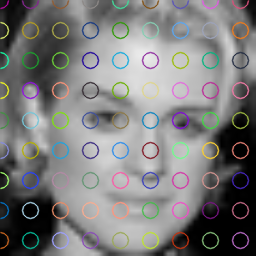

In [ ]:
# Draw the keypoints on the image

def display_img(image,kp,label):
    img_kp = cv2.drawKeypoints(image, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Show the image with keypoints
    cv2_imshow(img_kp)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
#display the first image in the dataset
for i in range(0,len(y_test)):
  if y_test[i] == preds[i]:
    print('Correct Classification')
    print('True Lable : ', str(y_test[i]))
    print('Predicted Lable : ', str(preds[i]))
    display_img(images[i],key_points[i],lables[i])
    break;